In [1]:
import medmnist
from medmnist import INFO, Evaluator

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np

/Users/carlosgil/.pyenv/versions/3.10.3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data_flag = "dermamnist"
data_flag = "bloodmnist"
# data_flag = "organamnist"
# data_flag = "organcmnist"
# data_flag = "organsmnist"
# data_flag = "pathmnist"
# data_flag = "octmnist"
# data_flag = "pneumoniamnist"

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
num_channels = info['n_channels']
num_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

print(info)
print(DataClass)

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}, 'n_channels': 3, 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421}, 'license': 'CC BY 4.0'}

In [3]:
#preprocessing
data_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[.5], std=[.5]) #output[channel] = (input[channel] - mean[channel]) / std[channel]
])

#loading
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

#encapsulating
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/carlosgil/.medmnist/bloodmnist.npz
Using downloaded and verified file: /Users/carlosgil/.medmnist/bloodmnist.npz


/Users/carlosgil/.pyenv/versions/3.10.3/lib/python3.10/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


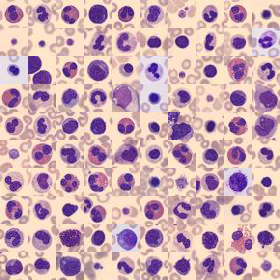

In [4]:
#visualization
train_dataset.montage(length=10)

In [7]:
# Feature Visualization via t-SNE

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_dataset(dload, sampled_inds=[], show_entire_dataset=False):
  input_tensors = []
  target_labels = []

  for inputs, targets in tqdm(dload):
    input_tensors.append(inputs)
    target_labels.append(targets)

  inputs = torch.cat(input_tensors, dim=0)
  target_labels = torch.cat(target_labels, dim=0).squeeze().numpy()

  num_inputs, _, _, _ = inputs.shape

  tsne = TSNE(n_components=2, random_state=0)
  embeddings = tsne.fit_transform(inputs.view(num_inputs, -1))

  _, ax = plt.subplots(figsize=(10, 10))

  if show_entire_dataset:
    for i in range(num_classes):
      embeddings_cluster = embeddings[target_labels == i]
      ax.scatter(embeddings_cluster[:, 0], embeddings_cluster[:, 1],label=f"Class {i}", s=3)
  else:
    ax.scatter(embeddings[:, 0], embeddings[:, 1], color='gray', s=3)
    embeddings_samples = embeddings[sampled_inds]
    ax.scatter(embeddings_samples[:, 0], embeddings_samples[:, 1],label="Sampled images", color='red', s=20)
  ax.legend()
  plt.show()

visualize_dataset(train_loader, [1,10,100,10_00])

100%|██████████| 94/94 [00:02<00:00, 41.18it/s]


In [ ]:
#Define CNN model

class Net(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(Net, self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU() #activation function
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(16, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer5 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc = nn.Sequential(
      nn.Linear(64 * 4 * 4, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

model = Net(in_channels=num_channels, num_classes=num_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
#model
for _ in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

    return (y_true, y_score)
        
print('==> Evaluating ...')
y_true_train, y_score_train = test('train')
y_true_test, y_score_test = test('test')

In [ ]:
"""
def getAUC(y_true, y_score, task):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
"""

In [ ]:
from netcal.scaling import TemperatureScaling

# ground_truth, confidences = y_true_test[:,0], y_score_test
ground_truth, confidences = y_true_train[:,0], y_score_train

temperature = TemperatureScaling()
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)

In [ ]:
from netcal.metrics import ECE

n_bins = 100

ece = ECE(n_bins)

uncalibrated_score = ece.measure(confidences,ground_truth)
calibrated_score = ece.measure(calibrated,ground_truth)

print(f'Uncalibrated ECE: {uncalibrated_score}')
print(f'Calibrated ECE: {calibrated_score}')

In [ ]:
from netcal.presentation import ReliabilityDiagram

n_bins = 100

diagram = ReliabilityDiagram(n_bins)
diagram.plot(confidences, ground_truth)  # visualize miscalibration of uncalibrated
diagram.plot(calibrated, ground_truth)   # visualize miscalibration of calibrated